In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('/content/Chicago_Crimes_2012_to_2017.csv')

In [ ]:
df.head()

,Unnamed: 0,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,3,10508693,HZ250496,05-03-2016 23:40,013XX S SAWYER AVE,486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,...,24.0,29.0,08B,1154907.0,1893681.0,2016,05-10-2016 15:56,41.864073,-87.706819,"(41.864073157, -87.706818608)"
1,89,10508695,HZ250409,05-03-2016 21:40,061XX S DREXEL AVE,486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,...,20.0,42.0,08B,1183066.0,1864330.0,2016,05-10-2016 15:56,41.782922,-87.604363,"(41.782921527, -87.60436317)"
2,197,10508697,HZ250503,05-03-2016 23:31,053XX W CHICAGO AVE,470,PUBLIC PEACE VIOLATION,RECKLESS CONDUCT,STREET,False,...,37.0,25.0,24,1140789.0,1904819.0,2016,05-10-2016 15:56,41.894908,-87.758372,"(41.894908283, -87.758371958)"
3,673,10508698,HZ250424,05-03-2016 22:10,049XX W FULTON ST,460,BATTERY,SIMPLE,SIDEWALK,False,...,28.0,25.0,08B,1143223.0,1901475.0,2016,05-10-2016 15:56,41.885687,-87.749516,"(41.885686845, -87.749515983)"
4,911,10508699,HZ250455,05-03-2016 22:00,003XX N LOTUS AVE,820,THEFT,$500 AND UNDER,RESIDENCE,False,...,28.0,25.0,6,1139890.0,1901675.0,2016,05-10-2016 15:56,41.886297,-87.761751,"(41.886297242, -87.761750709)"


In [ ]:
columns_to_drop = ['Case Number', 'IUCR', 'FBI Code', 'Unnamed: 0']
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

print("Final shape after cleaning:", df.shape)

df = df.dropna(subset=['Latitude', 'Longitude', 'Location', 'Location Description'])
df.loc[:, 'District'] = df['District'].fillna(df['District'].mode()[0])
df.loc[:, 'Ward'] = df['Ward'].fillna(df['Ward'].mode()[0])
df.loc[:, 'Community Area'] = df['Community Area'].fillna(df['Community Area'].mode()[0])

Final shape after cleaning: (1048575, 19)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1039270 entries, 0 to 1048574
Data columns (total 19 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   ID                    1039270 non-null  int64  
 1   Date                  1039270 non-null  object 
 2   Block                 1039270 non-null  object 
 3   Primary Type          1039270 non-null  object 
 4   Description           1039270 non-null  object 
 5   Location Description  1039270 non-null  object 
 6   Arrest                1039270 non-null  bool   
 7   Domestic              1039270 non-null  bool   
 8   Beat                  1039270 non-null  int64  
 9   District              1039270 non-null  float64
 10  Ward                  1039270 non-null  float64
 11  Community Area        1039270 non-null  float64
 12  X Coordinate          1039270 non-null  float64
 13  Y Coordinate          1039270 non-null  float64
 14  Year                  1039270 non-null 

In [ ]:
missing_values = df.isnull().sum()
missing_values

,0
ID,0
Date,0
Block,0
Primary Type,0
Description,0
Location Description,0
Arrest,0
Domestic,0
Beat,0
District,0


In [ ]:
df['Date'] = df['Date'].str.strip()
df['Date'] = df['Date'].str.replace('/', '-', regex=False)
df['Date'] = df['Date'].str.replace(r'\s*(AM|PM)', '', regex=True)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
invalid_dates = df[df['Date'].isna()]
print(invalid_dates['Date'].value_counts().head(10))
df = df[~df['Date'].isna()].copy()

df['Hour'] = df['Date'].dt.hour
df['Weekday'] = df['Date'].dt.weekday
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Season'] = df['Month'] % 12 // 3 + 1
df['Arrest'] = df['Arrest'].astype(int)
df['Domestic'] = df['Domestic'].astype(int)
le_primary = LabelEncoder()
df['Primary Type Encoded'] = le_primary.fit_transform(df['Primary Type'])
df.head()

Series([], Name: count, dtype: int64)


,ID,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,...,Year,Updated On,Latitude,Longitude,Location,Hour,Weekday,Month,Season,Primary Type Encoded
0,10508693,2016-05-03 23:40:00,013XX S SAWYER AVE,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,1,1,1022,10.0,...,2016,05-10-2016 15:56,41.864073,-87.706819,"(41.864073157, -87.706818608)",23,1,5,2,2
1,10508695,2016-05-03 21:40:00,061XX S DREXEL AVE,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,0,1,313,3.0,...,2016,05-10-2016 15:56,41.782922,-87.604363,"(41.782921527, -87.60436317)",21,1,5,2,2
2,10508697,2016-05-03 23:31:00,053XX W CHICAGO AVE,PUBLIC PEACE VIOLATION,RECKLESS CONDUCT,STREET,0,0,1524,15.0,...,2016,05-10-2016 15:56,41.894908,-87.758372,"(41.894908283, -87.758371958)",23,1,5,2,27
3,10508698,2016-05-03 22:10:00,049XX W FULTON ST,BATTERY,SIMPLE,SIDEWALK,0,0,1532,15.0,...,2016,05-10-2016 15:56,41.885687,-87.749516,"(41.885686845, -87.749515983)",22,1,5,2,2
4,10508699,2016-05-03 22:00:00,003XX N LOTUS AVE,THEFT,$500 AND UNDER,RESIDENCE,0,1,1523,15.0,...,2016,05-10-2016 15:56,41.886297,-87.761751,"(41.886297242, -87.761750709)",22,1,5,2,31


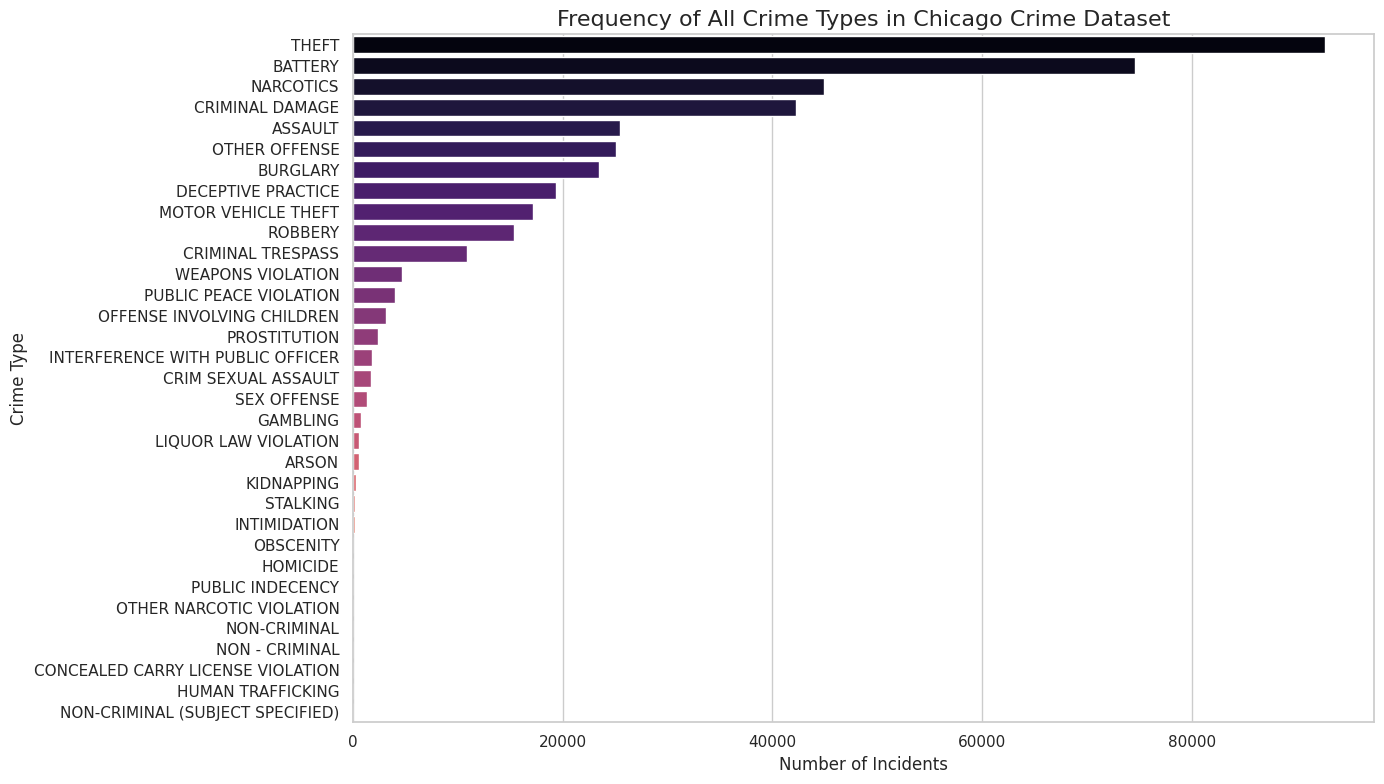

In [ ]:
sns.set(style="whitegrid")
crime_counts = df['Primary Type'].value_counts()
plt.figure(figsize=(14, 8))
sns.barplot(x=crime_counts.values, y=crime_counts.index, hue=crime_counts.index, palette='magma', dodge=False, legend=False)
plt.title('Frequency of All Crime Types in Chicago Crime Dataset', fontsize=16)
plt.ylabel('Crime Type', fontsize=12)
plt.xlabel('Number of Incidents', fontsize=12)
plt.tight_layout()
plt.show()

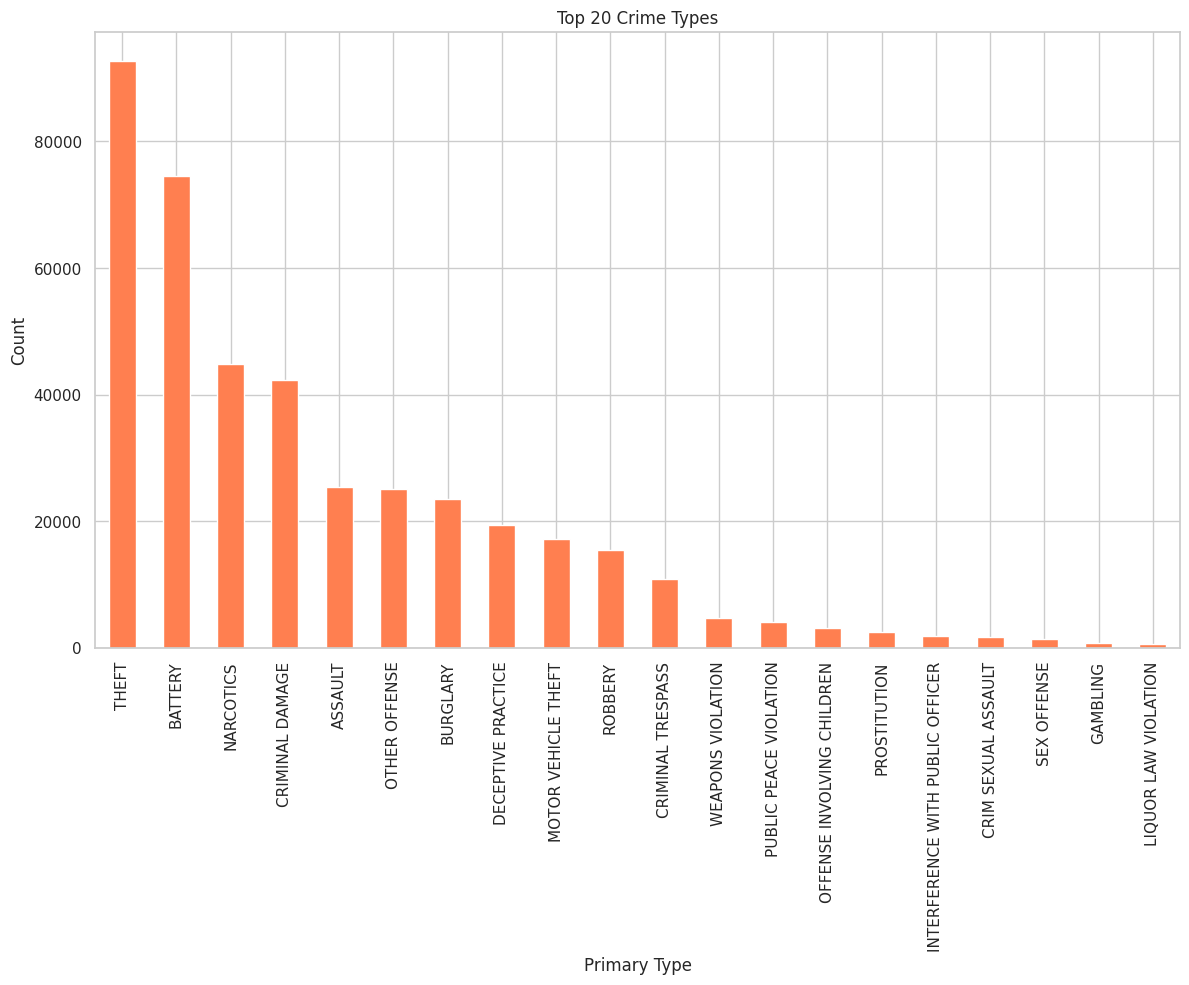

In [ ]:
plt.figure(figsize=(14, 8))
df['Primary Type'].value_counts().head(20).plot(kind='bar', color='coral')
plt.title('Top 20 Crime Types')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

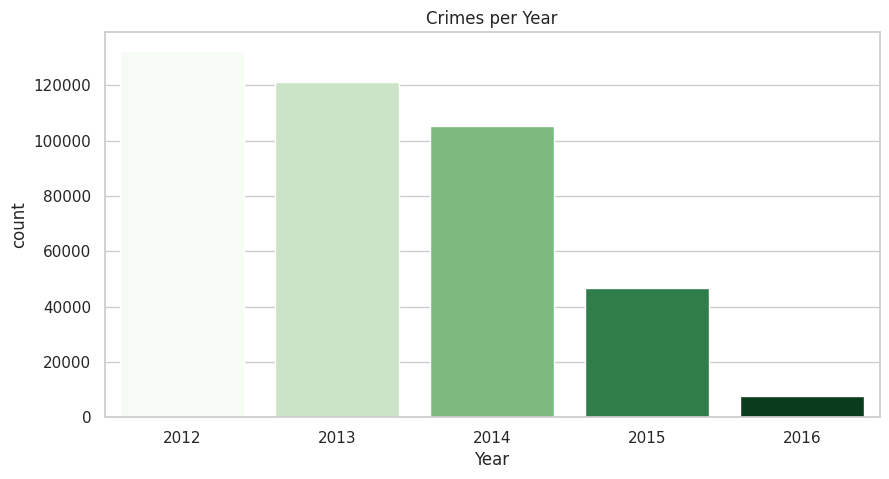

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(x='Year', data=df, palette='Greens', hue='Year', dodge=False, legend=False)
plt.title('Crimes per Year')
plt.show()

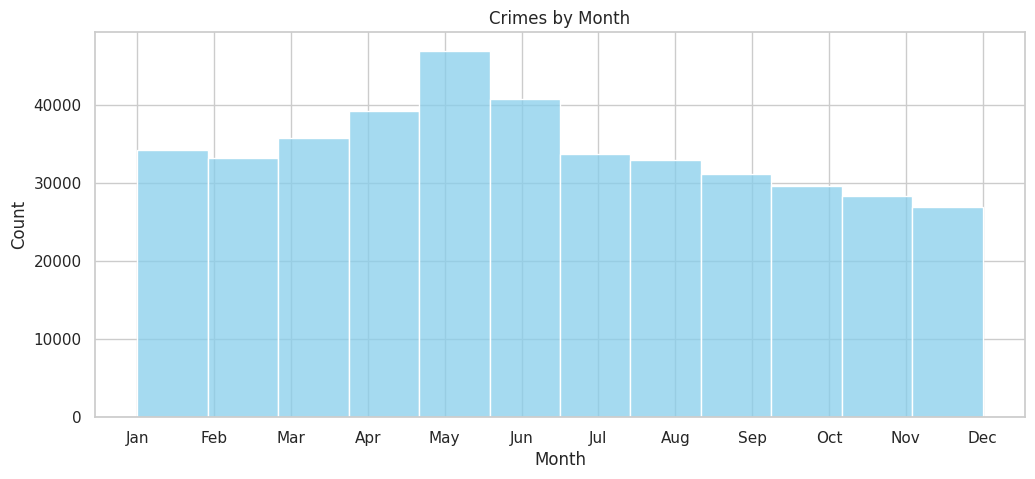

In [ ]:
plt.figure(figsize=(12, 5))
sns.histplot(df['Month'], bins=12, kde=False, color='skyblue')
plt.title('Crimes by Month')
plt.xlabel('Month')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

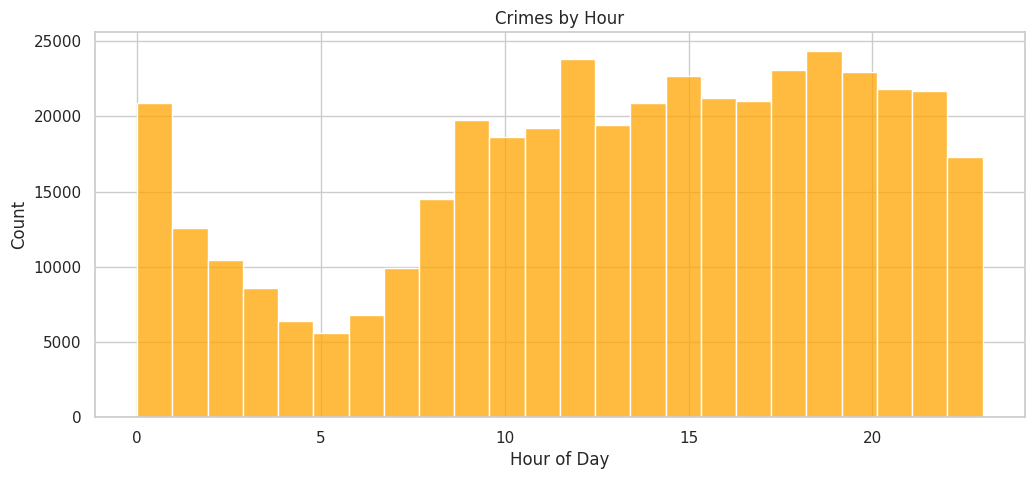

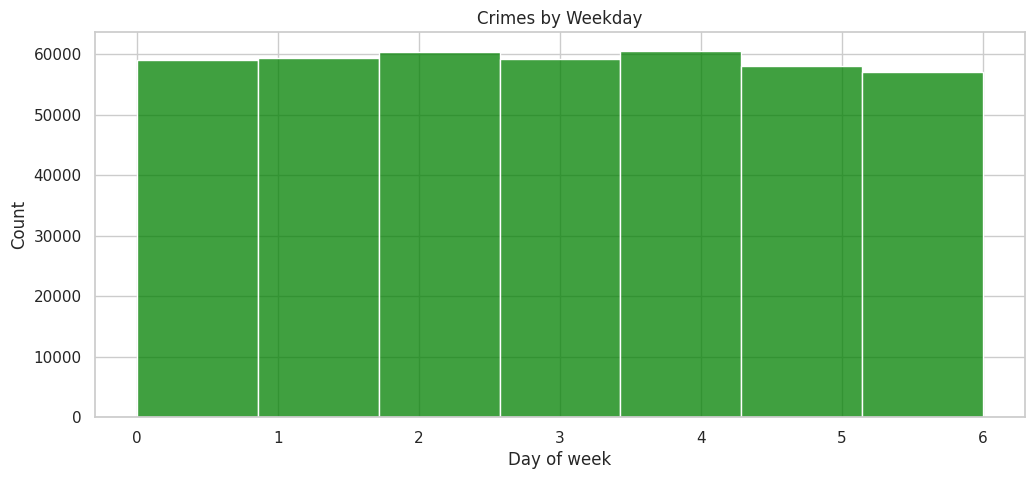

In [ ]:
plt.figure(figsize=(12, 5))
sns.histplot(df['Hour'], bins=24, kde=False, color='orange')
plt.title('Crimes by Hour')
plt.xlabel('Hour of Day')
plt.show()

plt.figure(figsize=(12, 5))
sns.histplot(df['Weekday'], bins=7, kde=False, color='green')
plt.title('Crimes by Weekday')
plt.xlabel('Day of week')
plt.show()

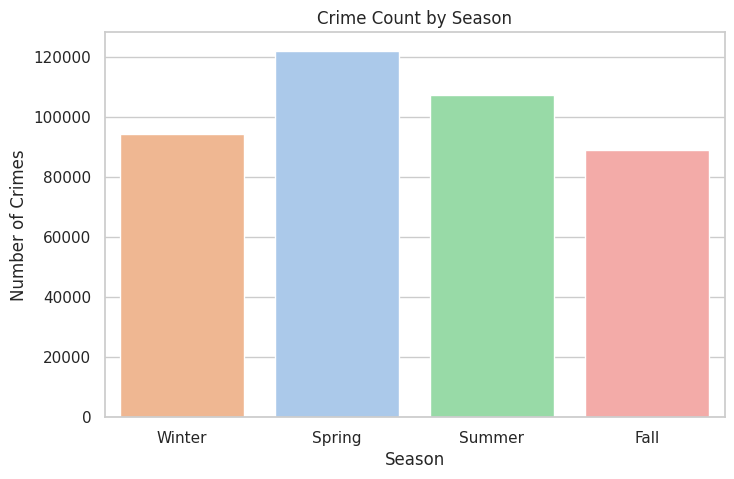

In [ ]:
season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
df['season_name'] = df['Season'].map(season_map)
plt.figure(figsize=(8, 5))
sns.countplot(x='season_name',hue='season_name', data=df, palette='pastel', order=['Winter', 'Spring', 'Summer', 'Fall'])
plt.title('Crime Count by Season')
plt.xlabel('Season')
plt.ylabel('Number of Crimes')
plt.show()

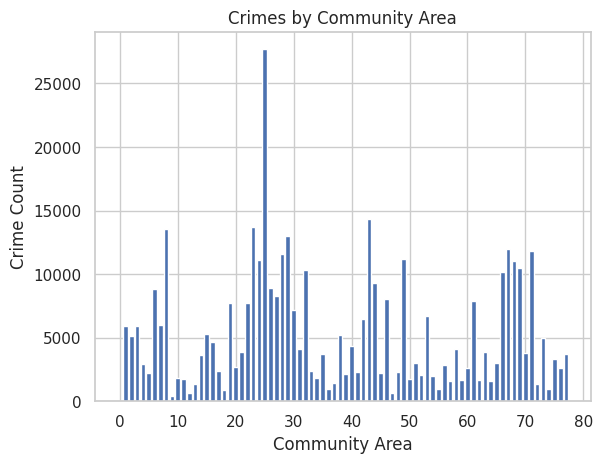

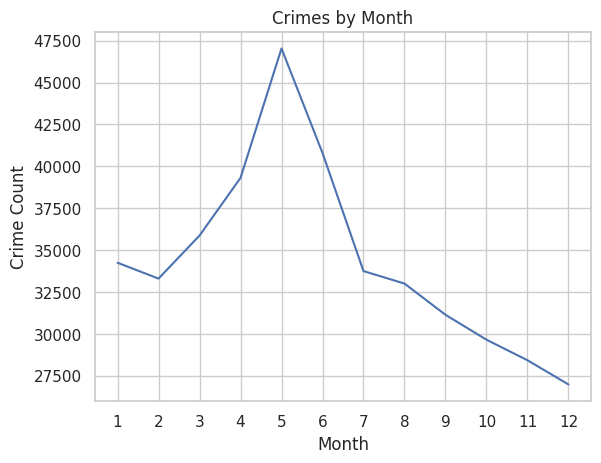

In [ ]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs='epsg:4326')
spatial_aggregation = gdf.groupby('Community Area').size().reset_index(name='CrimeCount')

plt.bar(spatial_aggregation['Community Area'], spatial_aggregation['CrimeCount'])
plt.title('Crimes by Community Area')
plt.xlabel('Community Area')
plt.ylabel('Crime Count')
plt.show()

gdf['Month'] = gdf['Date'].dt.month
temporal_aggregation = gdf.groupby('Month').size().reset_index(name='CrimeCount')
plt.plot(temporal_aggregation['Month'], temporal_aggregation['CrimeCount'])
plt.title('Crimes by Month')
plt.xlabel('Month')
plt.ylabel('Crime Count')
plt.xticks(range(1, 13))
plt.show()

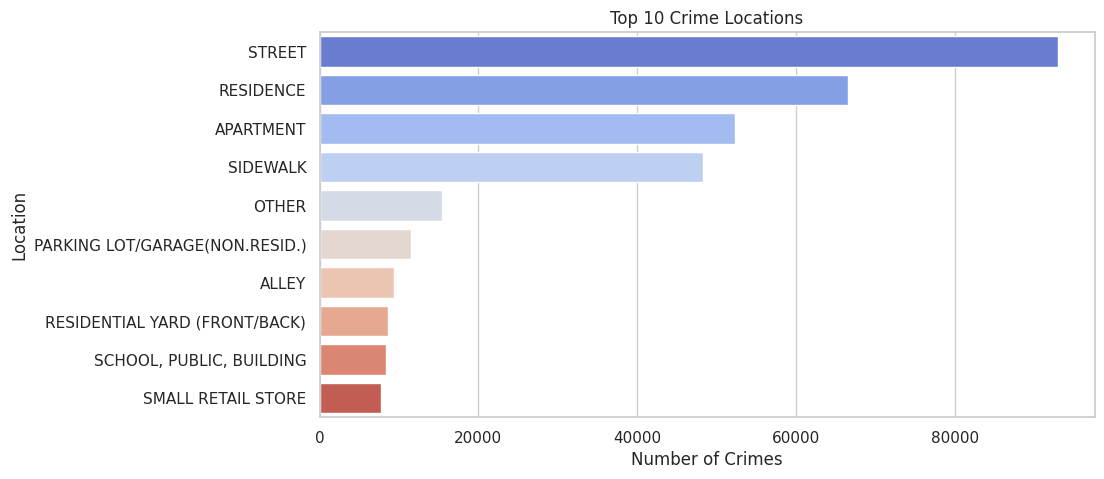

In [ ]:
plt.figure(figsize=(10, 5))
top_locs = df['Location Description'].value_counts().nlargest(10)
sns.barplot(x=top_locs.values, y=top_locs.index,hue=top_locs.index, palette='coolwarm',legend=False )
plt.title('Top 10 Crime Locations')
plt.xlabel('Number of Crimes')
plt.ylabel('Location')
plt.show()

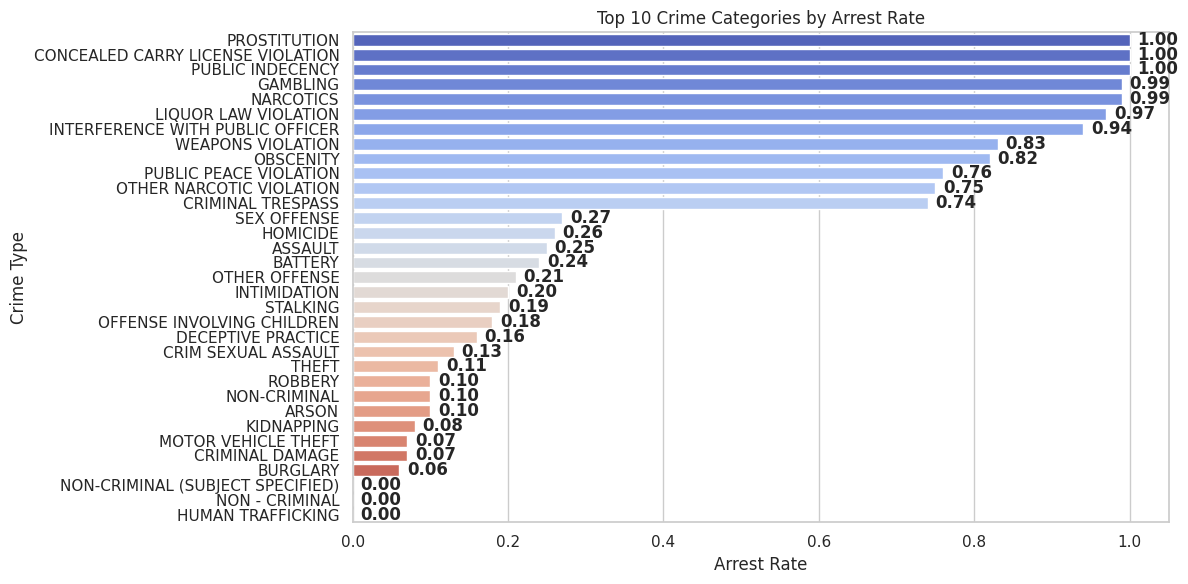

In [ ]:
arrest_rate = df.groupby('Primary Type Encoded')['Arrest'].mean()
arrest_rate_rounded = arrest_rate.round(2)

sorted_indices = arrest_rate_rounded.argsort()[::-1]
sorted_rates = arrest_rate_rounded[sorted_indices]
sorted_crimes = le_primary.inverse_transform(arrest_rate.index[sorted_indices])

plt.figure(figsize=(12, 6))
sns.barplot(
    x=sorted_rates,
    y=sorted_crimes,
    hue=sorted_crimes,
    palette='coolwarm',
    dodge=False,
    legend=False
)

plt.title('Top 10 Crime Categories by Arrest Rate')
plt.xlabel('Arrest Rate')
plt.ylabel('Crime Type')
plt.xlim(0, 1.05)

for i, v in enumerate(sorted_rates):
    plt.text(v + 0.01, i, f'{v:.2f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

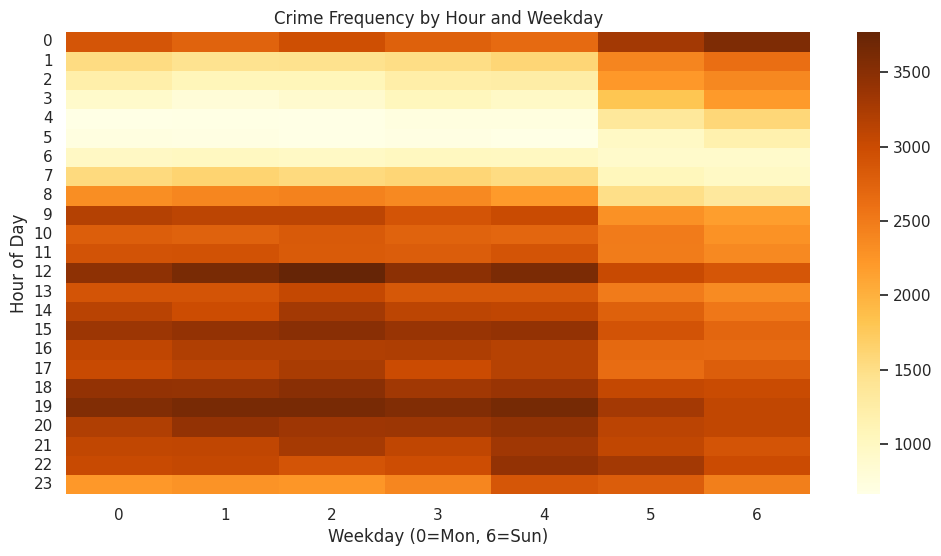

In [ ]:
pivot = df.pivot_table(index='Hour', columns='Weekday', aggfunc='size', fill_value=0)
plt.figure(figsize=(12, 6))
sns.heatmap(pivot, cmap='YlOrBr')
plt.title('Crime Frequency by Hour and Weekday')
plt.xlabel('Weekday (0=Mon, 6=Sun)')
plt.ylabel('Hour of Day')
plt.show()

In [ ]:
df_copy = df.copy(deep=True)
df_copy.head()

,ID,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,...,Updated On,Latitude,Longitude,Location,Hour,Weekday,Month,Season,Primary Type Encoded,season_name
0,10508693,2016-05-03 23:40:00,013XX S SAWYER AVE,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,1,1,1022,10.0,...,05-10-2016 15:56,41.864073,-87.706819,"(41.864073157, -87.706818608)",23,1,5,2,2,Spring
1,10508695,2016-05-03 21:40:00,061XX S DREXEL AVE,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,0,1,313,3.0,...,05-10-2016 15:56,41.782922,-87.604363,"(41.782921527, -87.60436317)",21,1,5,2,2,Spring
2,10508697,2016-05-03 23:31:00,053XX W CHICAGO AVE,PUBLIC PEACE VIOLATION,RECKLESS CONDUCT,STREET,0,0,1524,15.0,...,05-10-2016 15:56,41.894908,-87.758372,"(41.894908283, -87.758371958)",23,1,5,2,27,Spring
3,10508698,2016-05-03 22:10:00,049XX W FULTON ST,BATTERY,SIMPLE,SIDEWALK,0,0,1532,15.0,...,05-10-2016 15:56,41.885687,-87.749516,"(41.885686845, -87.749515983)",22,1,5,2,2,Spring
4,10508699,2016-05-03 22:00:00,003XX N LOTUS AVE,THEFT,$500 AND UNDER,RESIDENCE,0,1,1523,15.0,...,05-10-2016 15:56,41.886297,-87.761751,"(41.886297242, -87.761750709)",22,1,5,2,31,Spring


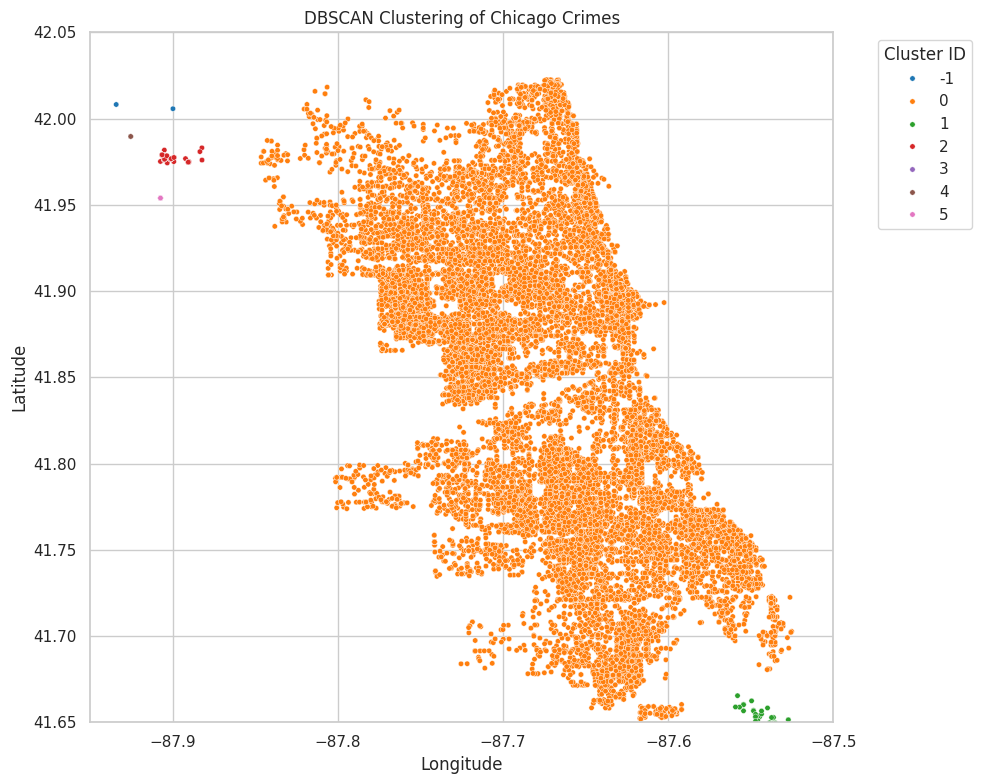

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

df_spatial = df.dropna(subset=['Latitude', 'Longitude']).sample(n=20000, random_state=42).copy()

df_spatial['Latitude_orig'] = df_spatial['Latitude']
df_spatial['Longitude_orig'] = df_spatial['Longitude']

scaler = StandardScaler()
coords_scaled = scaler.fit_transform(df_spatial[['Latitude', 'Longitude']])

db = DBSCAN(eps=0.2, min_samples=2)
df_spatial['dbscan_cluster'] = db.fit_predict(coords_scaled)

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_spatial,
    x='Longitude_orig', y='Latitude_orig',
    hue='dbscan_cluster', palette='tab10', s=15, legend='full'
)

plt.xlim(-87.95, -87.5)
plt.ylim(41.65, 42.05)

plt.title('DBSCAN Clustering of Chicago Crimes')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Cluster ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Spatialtemporal DBSCAN

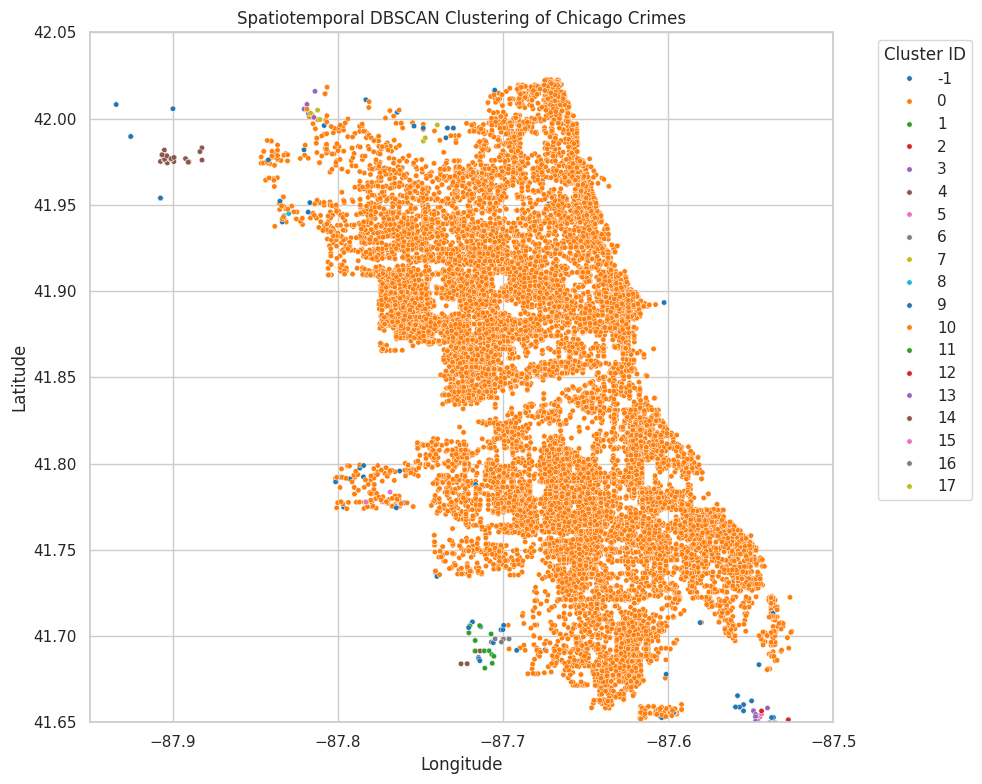

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


df_st = df.dropna(subset=['Latitude', 'Longitude', 'Hour']).sample(n=20000, random_state=42).copy()

df_st['Latitude_orig'] = df_st['Latitude']
df_st['Longitude_orig'] = df_st['Longitude']

features = df_st[['Latitude', 'Longitude', 'Hour']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

db = DBSCAN(eps=0.2, min_samples=3)
df_st['st_dbscan_cluster'] = db.fit_predict(features_scaled)

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_st, x='Longitude_orig', y='Latitude_orig',
    hue='st_dbscan_cluster', palette='tab10', s=15, legend='full'
)

plt.xlim(-87.95, -87.5)
plt.ylim(41.65, 42.05)

plt.title('Spatiotemporal DBSCAN Clustering of Chicago Crimes')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Cluster ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score

df_spatial = df.dropna(subset=['Latitude', 'Longitude']).sample(n=20000, random_state=42).copy()
coords = df_spatial[['Latitude', 'Longitude']]
coords_scaled = StandardScaler().fit_transform(coords)

db = DBSCAN(eps=0.2, min_samples=2)
labels_db = db.fit_predict(coords_scaled)
df_spatial['dbscan_cluster'] = labels_db

mask = labels_db != -1
if len(set(labels_db[mask])) > 1:
    ch_score_spatial = calinski_harabasz_score(coords_scaled[mask], labels_db[mask])
    db_score_spatial = davies_bouldin_score(coords_scaled[mask], labels_db[mask])
    sil_score_spatial = silhouette_score(coords_scaled[mask], labels_db[mask])
else:
    ch_score_spatial = db_score_spatial = sil_score_spatial = float('nan')

print(f"DBSCAN - CH Score: {ch_score_spatial:.2f}, DB Score: {db_score_spatial:.2f}, Silhouette Score: {sil_score_spatial:.2f}")

df_st = df.dropna(subset=['Latitude', 'Longitude', 'Hour']).sample(n=20000, random_state=42).copy()
features = df_st[['Latitude', 'Longitude', 'Hour']]
features_scaled = StandardScaler().fit_transform(features)

st_db = DBSCAN(eps=0.2, min_samples=2)
labels_st = st_db.fit_predict(features_scaled)
df_st['st_dbscan_cluster'] = labels_st

mask_st = labels_st != -1
if len(set(labels_st[mask_st])) > 1:
    ch_score_st = calinski_harabasz_score(features_scaled[mask_st], labels_st[mask_st])
    db_score_st = davies_bouldin_score(features_scaled[mask_st], labels_st[mask_st])
    sil_score_st = silhouette_score(features_scaled[mask_st], labels_st[mask_st])
else:
    ch_score_st = db_score_st = sil_score_st = float('nan')

print(f"ST-DBSCAN - CH Score: {ch_score_st:.2f}, DB Score: {db_score_st:.2f}, Silhouette Score: {sil_score_st:.2f}")

DBSCAN - CH Score: 1890.58, DB Score: 0.31, Silhouette Score: 0.27
ST-DBSCAN - CH Score: 29.12, DB Score: 0.75, Silhouette Score: -0.32


## ST-GCN

In [ ]:
pip install torch torch_geometric torch_geometric_temporal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Total nodes: 1084
Total edges: 12018


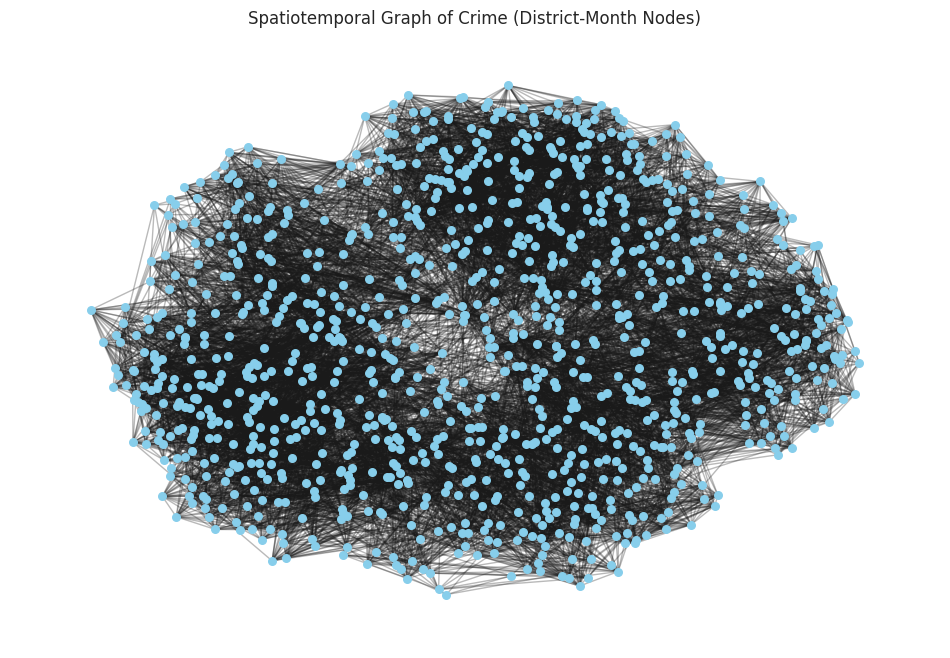

In [83]:
import pandas as pd
import networkx as nx
import torch
from torch.nn import MSELoss, Dropout
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric_temporal.signal import DynamicGraphTemporalSignal
from torch_geometric_temporal.nn.recurrent import A3TGCN2

df['YearMonth'] = df['Date'].dt.to_period('M').astype(str)
grouped = df.groupby(['District', 'YearMonth']).agg({
    'Primary Type Encoded': 'mean',
    'Arrest': 'mean',
    'Latitude': 'mean',
    'Longitude': 'mean',
    'Primary Type': 'count'
}).rename(columns={'Primary Type': 'crime_count'}).reset_index()
grouped['Node'] = grouped['District'].astype(str) + '_' + grouped['YearMonth']


G = nx.Graph()
for _, row in grouped.iterrows():
    node_id = row['Node']
    G.add_node(node_id,
               crime_code=row['Primary Type Encoded'],
               arrest_rate=row['Arrest'],
               crime_count=row['crime_count'],
               latitude=row['Latitude'],
               longitude=row['Longitude'],
               district=row['District'],
               year_month=row['YearMonth'])

nodes = list(G.nodes(data=True))
for i in range(len(nodes)):
    for j in range(i+1, len(nodes)):
        node_i, attr_i = nodes[i]
        node_j, attr_j = nodes[j]

        if attr_i['district'] == attr_j['district']:
            diff_months = abs((pd.Period(attr_i['year_month']) - pd.Period(attr_j['year_month'])).n)
            if diff_months == 1:
                G.add_edge(node_i, node_j)

        elif attr_i['year_month'] == attr_j['year_month']:
            G.add_edge(node_i, node_j)

print(f"Total nodes: {G.number_of_nodes()}")
print(f"Total edges: {G.number_of_edges()}")

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42, k=0.5)
nx.draw_networkx_nodes(G, pos, node_size=30, node_color='skyblue')
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.title("Spatiotemporal Graph of Crime (District-Month Nodes)")
plt.axis('off')
plt.show()

In [84]:
from sklearn.preprocessing import StandardScaler

all_node_features = []
for _, attr in G.nodes(data=True):
    feat = [
        attr['crime_count'],
        attr['arrest_rate'],
        attr['latitude'],
        attr['longitude'],
        attr['crime_code']
    ]
    all_node_features.append(feat)

scaler = StandardScaler()
scaler.fit(all_node_features)

edge_indices, edge_weights, features, targets = [], [], [], []
all_months = sorted({attr['year_month'] for _, attr in G.nodes(data=True)})

for month in all_months:
    nodes_in_month = [n for n, attr in G.nodes(data=True) if attr['year_month'] == month]
    if not nodes_in_month:
        continue

    local_node_map = {n: i for i, n in enumerate(nodes_in_month)}
    month_features, month_targets = [], []

    for n in nodes_in_month:
        attr = G.nodes[n]
        feat = [
            attr['crime_count'],
            attr['arrest_rate'],
            attr['latitude'],
            attr['longitude'],
            attr['crime_code']
        ]
        feat_scaled = scaler.transform([feat])[0]
        month_features.append(feat_scaled)
        month_targets.append(attr['arrest_rate'])

    features.append(torch.tensor(month_features, dtype=torch.float).unsqueeze(2))
    targets.append(torch.tensor(month_targets, dtype=torch.float))

    edge_list = [(local_node_map[u], local_node_map[v])
                 for u, v in G.edges()
                 if u in nodes_in_month and v in nodes_in_month]

    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous() if edge_list else torch.empty((2, 0), dtype=torch.long)
    edge_indices.append(edge_index)
    edge_weights.append(torch.ones(edge_index.shape[1]))


In [85]:
class STGCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels, periods=12, batch_size=1, dropout_rate=0.3):
        super(STGCN, self).__init__()
        self.model = A3TGCN2(
            in_channels=in_channels,
            out_channels=out_channels,
            periods=periods,
            batch_size=batch_size
        )
        self.dropout = Dropout(dropout_rate)
        self.linear = torch.nn.Linear(out_channels, 1)

    def forward(self, x, edge_index):
        out = self.model(x, edge_index)
        out = self.dropout(out)
        out = self.linear(out)
        return out

In [86]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_snapshots = list(dataset)[:7]
test_snapshots = list(dataset)[7:]

model = STGCN(in_channels=3, out_channels=1, periods=1, batch_size=1, dropout_rate=0.3).to(device)
optimizer = Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
loss_fn = MSELoss()

best_test_loss = float('inf')
patience = 5
patience_counter = 0

train_losses = []
test_losses = []

model.train()
for epoch in range(50):
    total_train_loss = 0.0
    total_test_loss = 0.0

    for snapshot in train_snapshots:
        x = snapshot.x.unsqueeze(0).to(device)
        edge_index = snapshot.edge_index.to(device)
        y = snapshot.y.clone().detach().to(torch.float32).to(device).view(-1, 1)

        optimizer.zero_grad()
        y_hat = model(x, edge_index)
        loss = loss_fn(y_hat.squeeze(0), y)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    model.eval()
    with torch.no_grad():
        for snapshot in test_snapshots:
            x = snapshot.x.unsqueeze(0).to(device)
            edge_index = snapshot.edge_index.to(device)
            y = torch.tensor(snapshot.y, dtype=torch.float32).to(device).view(-1, 1)
            y_hat = model(x, edge_index)
            total_test_loss += loss_fn(y_hat, y).item()
    model.train()

    train_losses.append(total_train_loss)
    test_losses.append(total_test_loss)
    print(f"Epoch {epoch+1:02d} | Train Loss: {total_train_loss:.4f} | Test Loss: {total_test_loss:.4f}")

    if total_test_loss < best_test_loss:
        best_test_loss = total_test_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_stgcn_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch+1} — best test loss: {best_test_loss:.4f}")
            break

<ipython-input-86-6f869a4c52ad>:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(snapshot.y, dtype=torch.float32).to(device).view(-1, 1)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([22, 1])) that is different to the input size (torch.Size([1, 22, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([23, 1])) that is different to the input size (torch.Size([1, 23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.re

Epoch 01 | Train Loss: 8.3858 | Test Loss: 55.2931
Epoch 02 | Train Loss: 6.5076 | Test Loss: 24.3131
Epoch 03 | Train Loss: 2.2606 | Test Loss: 19.2883
Epoch 04 | Train Loss: 1.8945 | Test Loss: 16.0708
Epoch 05 | Train Loss: 1.3611 | Test Loss: 12.9144
Epoch 06 | Train Loss: 1.0496 | Test Loss: 10.3437
Epoch 07 | Train Loss: 0.7911 | Test Loss: 8.4872
Epoch 08 | Train Loss: 0.5548 | Test Loss: 7.1881
Epoch 09 | Train Loss: 0.4032 | Test Loss: 6.3026
Epoch 10 | Train Loss: 0.3910 | Test Loss: 5.7068
Epoch 11 | Train Loss: 0.3671 | Test Loss: 5.3068
Epoch 12 | Train Loss: 0.2835 | Test Loss: 5.8445
Epoch 13 | Train Loss: 0.2582 | Test Loss: 4.8132
Epoch 14 | Train Loss: 0.2486 | Test Loss: 4.6118
Epoch 15 | Train Loss: 0.2823 | Test Loss: 4.4927
Epoch 16 | Train Loss: 0.2395 | Test Loss: 4.4293
Epoch 17 | Train Loss: 0.2717 | Test Loss: 4.3845
Epoch 18 | Train Loss: 0.3053 | Test Loss: 4.3429
Epoch 19 | Train Loss: 0.1849 | Test Loss: 4.3224
Epoch 20 | Train Loss: 0.2249 | Test Loss: 4

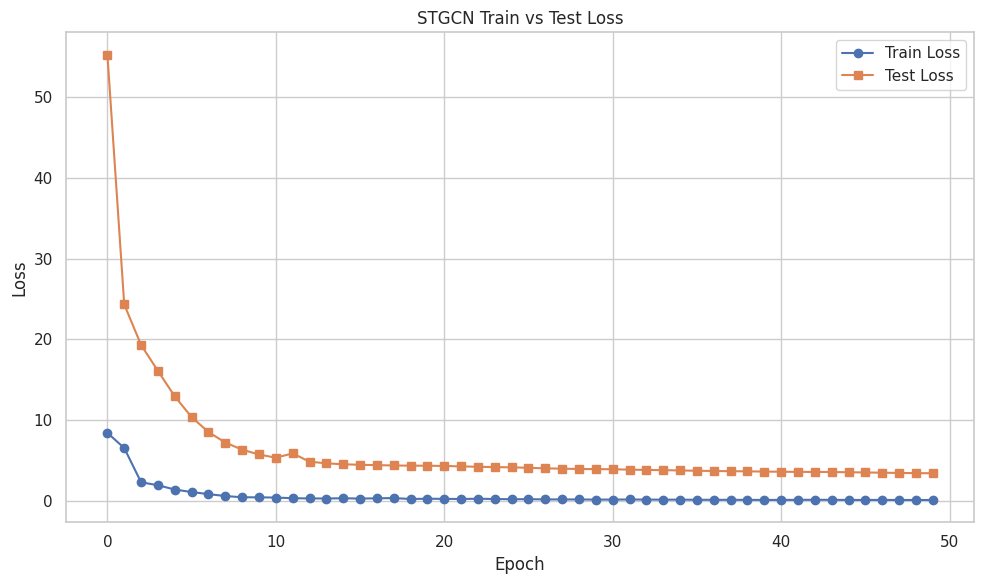

In [87]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(test_losses, label='Test Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('STGCN Train vs Test Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [88]:
def regression_accuracy(y_true, y_pred, tolerance=0.05):
    correct = (torch.abs(y_true - y_pred) <= tolerance).sum().item()
    total = y_true.numel()
    return correct / total

def r2_score_torch(y_true, y_pred):
    y_true_mean = torch.mean(y_true)
    ss_total = torch.sum((y_true - y_true_mean) ** 2)
    ss_res = torch.sum((y_true - y_pred) ** 2)
    return 1 - ss_res / ss_total

model.load_state_dict(torch.load("best_stgcn_model.pth"))
model.eval()

test_accuracy_total = 0.0
test_r2_total = 0.0
test_loss_total = 0.0
count = 0

with torch.no_grad():
    for snapshot in test_snapshots:
        x = snapshot.x.unsqueeze(0).to(device)
        edge_index = snapshot.edge_index.to(device)
        y = snapshot.y.to(torch.float32).to(device).view(-1, 1)
        y_hat = model(x, edge_index)

        acc = regression_accuracy(y, y_hat)
        r2 = r2_score_torch(y, y_hat).item()
        loss = loss_fn(y_hat, y).item()

        test_accuracy_total += acc
        test_r2_total += r2
        test_loss_total += loss
        count += 1

avg_test_acc = test_accuracy_total / count
avg_test_r2 = test_r2_total / count
avg_test_loss = test_loss_total / count

print(f"Final Evaluation on Test Set:")
print(f"Average Loss: {avg_test_loss:.4f}")
print(f"Average Accuracy (±0.05 tolerance): {avg_test_acc:.3f}")

Final Evaluation on Test Set:
Average Loss: 0.0734
Average Accuracy (±0.05 tolerance): 0.447


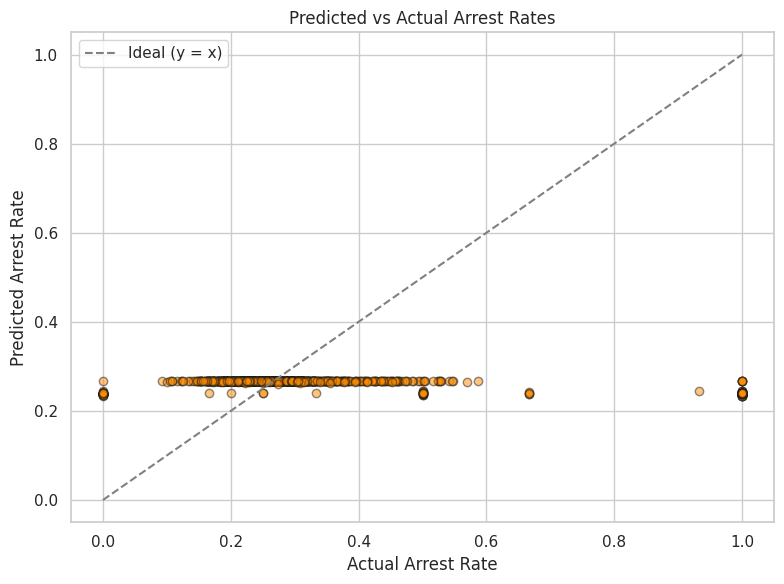

In [89]:
import matplotlib.pyplot as plt

all_preds = []
all_actuals = []

model.eval()
with torch.no_grad():
    for snapshot in test_snapshots:
        x = snapshot.x.unsqueeze(0).to(device)
        edge_index = snapshot.edge_index.to(device)
        y = snapshot.y.to(torch.float32).view(-1, 1)
        y_hat = model(x, edge_index)

        all_preds.extend(y_hat.cpu().numpy().flatten())
        all_actuals.extend(y.cpu().numpy().flatten())

plt.figure(figsize=(8, 6))
plt.scatter(all_actuals, all_preds, alpha=0.5, color='darkorange', edgecolor='k')
plt.plot([0, 1], [0, 1], '--', color='gray', linewidth=1.5, label='Ideal (y = x)')
plt.xlabel('Actual Arrest Rate')
plt.ylabel('Predicted Arrest Rate')
plt.title('Predicted vs Actual Arrest Rates')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [90]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

model.load_state_dict(torch.load("best_stgcn_model.pth"))
model.eval()

all_preds = []
all_true = []

with torch.no_grad():
    for snapshot in test_snapshots:
        x = snapshot.x.unsqueeze(0).to(device)
        edge_index = snapshot.edge_index.to(device)
        y_true = torch.tensor(snapshot.y, dtype=torch.float32).cpu().numpy()
        y_hat = model(x, edge_index).cpu().numpy().flatten()

        all_preds.extend(y_hat)
        all_true.extend(y_true)

mae = mean_absolute_error(all_true, all_preds)
rmse = math.sqrt(mean_squared_error(all_true, all_preds))

print(f"\n📊 Evaluation on Test Set:")
print(f"➡️ MAE : {mae:.4f}")
print(f"➡️ RMSE: {rmse:.4f}")


📊 Evaluation on Test Set:
➡️ MAE : 0.1167
➡️ RMSE: 0.2202


<ipython-input-90-c58b7139d6b2>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_true = torch.tensor(snapshot.y, dtype=torch.float32).cpu().numpy()


In [91]:
results = []

model.eval()
with torch.no_grad():
    for snapshot in test_snapshots:
        x = snapshot.x.unsqueeze(0).to(device)
        edge_index = snapshot.edge_index.to(device)
        y_true = snapshot.y.clone().detach().to(torch.float32).view(-1)
        y_pred = model(x, edge_index).squeeze(0).squeeze(1).cpu()

        for actual, pred in zip(y_true.cpu(), y_pred):
            results.append({
                'Actual Arrest Rate': actual.item(),
                'Predicted Arrest Rate': pred.item(),
                'Absolute Error': abs(actual.item() - pred.item())
            })

results_df = pd.DataFrame(results)
best_predictions = results_df.nsmallest(10, 'Absolute Error')
worst_predictions = results_df.nlargest(10, 'Absolute Error')

print("Top 10 Best Predictions (Smallest Errors):")
display(best_predictions)
print("\nTop 10 Worst Predictions (Largest Errors):")
display(worst_predictions)

Top 10 Best Predictions (Smallest Errors):


,Actual Arrest Rate,Predicted Arrest Rate,Absolute Error
460,0.267974,0.267969,0.000005
136,0.267890,0.267969,0.000079
288,0.267717,0.267969,0.000253
313,0.268293,0.267969,0.000323
177,0.268734,0.267969,0.000765
465,0.268765,0.267969,0.000796
246,0.267133,0.267969,0.000836
227,0.267091,0.267969,0.000879
262,0.266990,0.267969,0.000979
515,0.266990,0.267969,0.000979



Top 10 Worst Predictions (Largest Errors):


,Actual Arrest Rate,Predicted Arrest Rate,Absolute Error
776,1.0,0.234104,0.765896
814,1.0,0.234105,0.765895
858,1.0,0.234106,0.765894
869,1.0,0.234121,0.765879
826,1.0,0.234121,0.765879
782,1.0,0.235392,0.764608
815,1.0,0.235841,0.764159
827,1.0,0.235853,0.764147
841,1.0,0.235855,0.764145
783,1.0,0.236713,0.763287


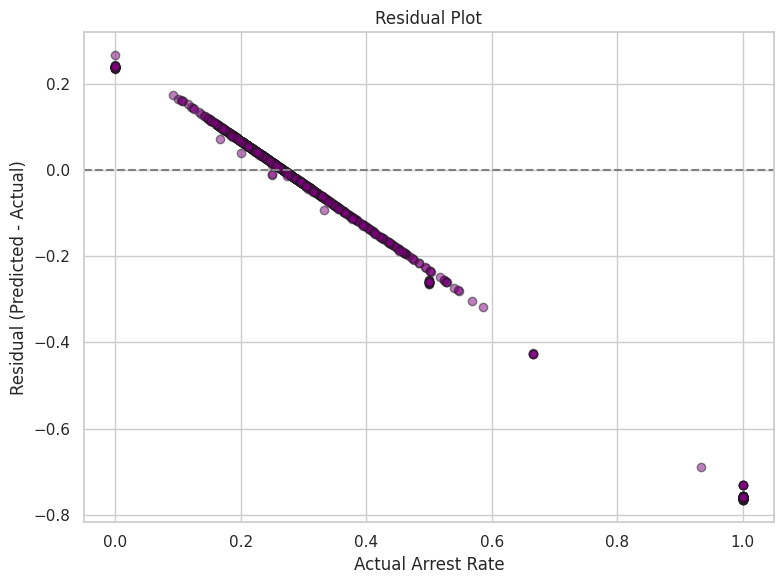

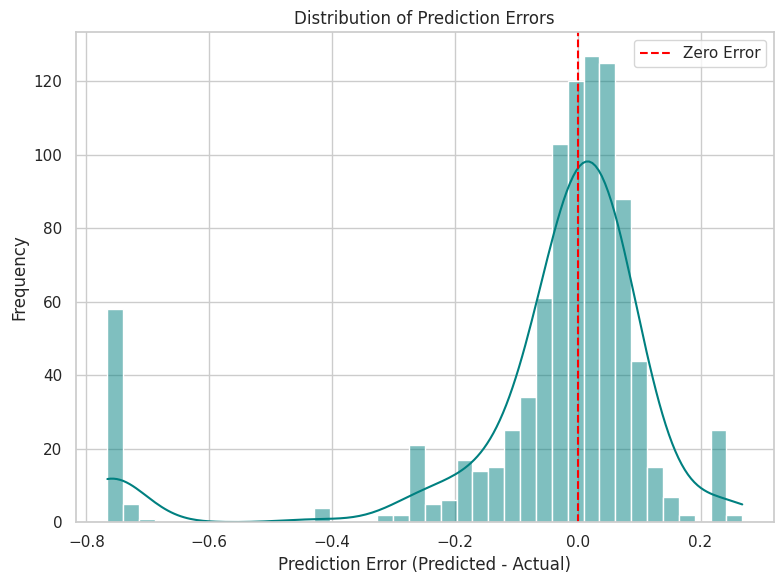

In [95]:
residuals = np.array(all_preds) - np.array(all_actuals)

plt.figure(figsize=(8, 6))
plt.scatter(all_actuals, residuals, alpha=0.5, color='purple', edgecolor='k')
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel('Actual Arrest Rate')
plt.ylabel('Residual (Predicted - Actual)')
plt.title('Residual Plot')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=40, kde=True, color='teal')
plt.axvline(0, linestyle='--', color='red', label='Zero Error')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error (Predicted - Actual)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

<ipython-input-96-aecb3227e37b>:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acc_by_bin = df_eval.groupby('Actual Bin')['Correct'].mean()


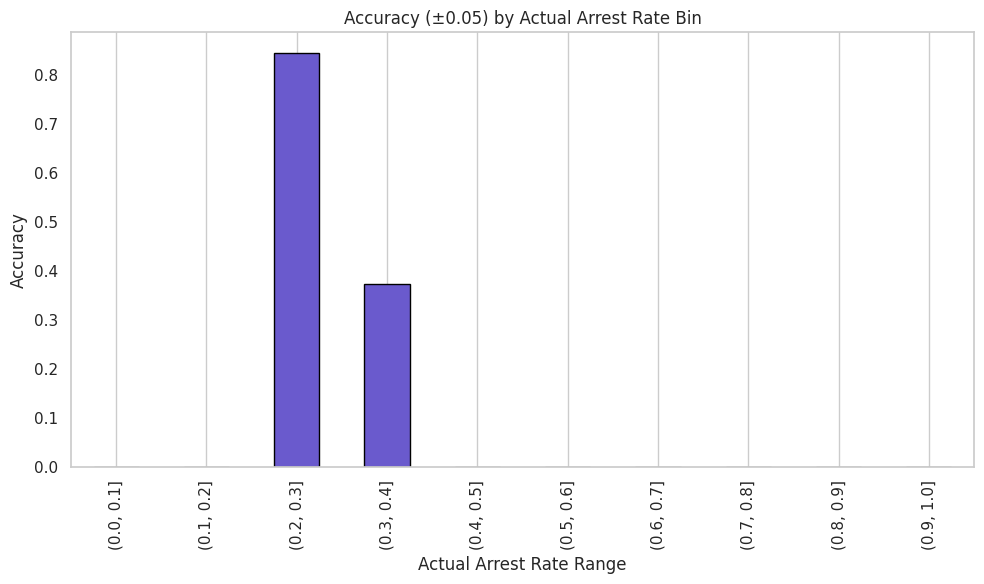

In [96]:
df_eval = pd.DataFrame({
    'Actual': all_actuals,
    'Predicted': all_preds
})
df_eval['Correct'] = (np.abs(df_eval['Predicted'] - df_eval['Actual']) <= 0.05)
df_eval['Actual Bin'] = pd.cut(df_eval['Actual'], bins=np.arange(0, 1.1, 0.1))

acc_by_bin = df_eval.groupby('Actual Bin')['Correct'].mean()

plt.figure(figsize=(10, 6))
acc_by_bin.plot(kind='bar', color='slateblue', edgecolor='black')
plt.title('Accuracy (±0.05) by Actual Arrest Rate Bin')
plt.ylabel('Accuracy')
plt.xlabel('Actual Arrest Rate Range')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


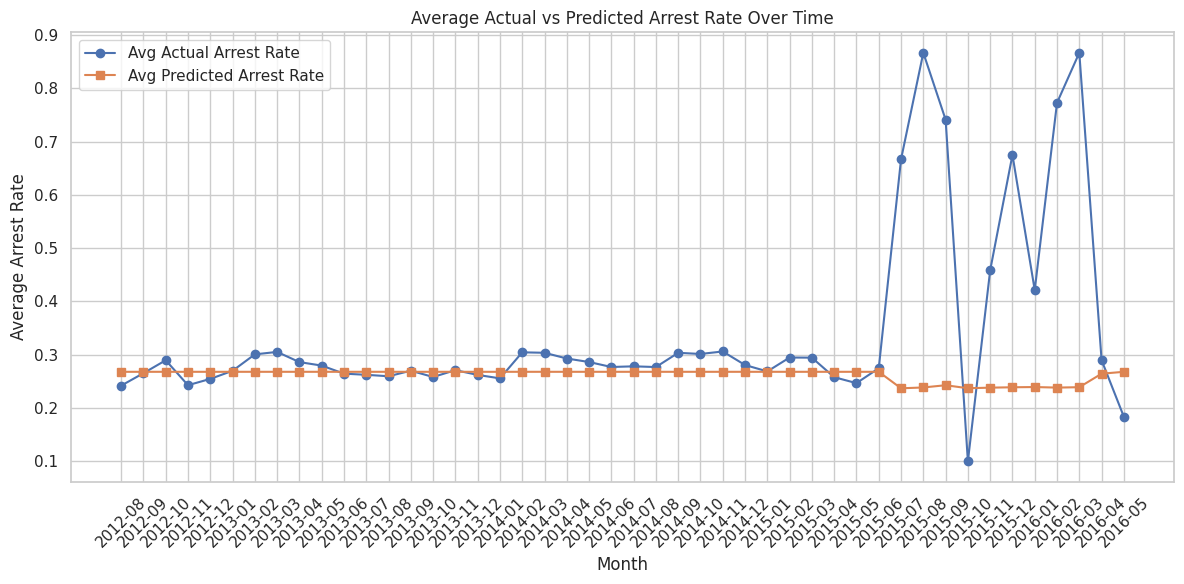

In [97]:
monthly_results = []

for snapshot, month in zip(test_snapshots, all_months[len(train_snapshots):]):
    actual = snapshot.y.numpy()
    pred = model(snapshot.x.unsqueeze(0).to(device), snapshot.edge_index.to(device)).squeeze(0).cpu().detach().numpy()

    monthly_results.append({
        'month': month,
        'avg_actual': np.mean(actual),
        'avg_predicted': np.mean(pred)
    })

df_monthly = pd.DataFrame(monthly_results)

plt.figure(figsize=(12, 6))
plt.plot(df_monthly['month'], df_monthly['avg_actual'], label='Avg Actual Arrest Rate', marker='o')
plt.plot(df_monthly['month'], df_monthly['avg_predicted'], label='Avg Predicted Arrest Rate', marker='s')
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Average Arrest Rate')
plt.title('Average Actual vs Predicted Arrest Rate Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


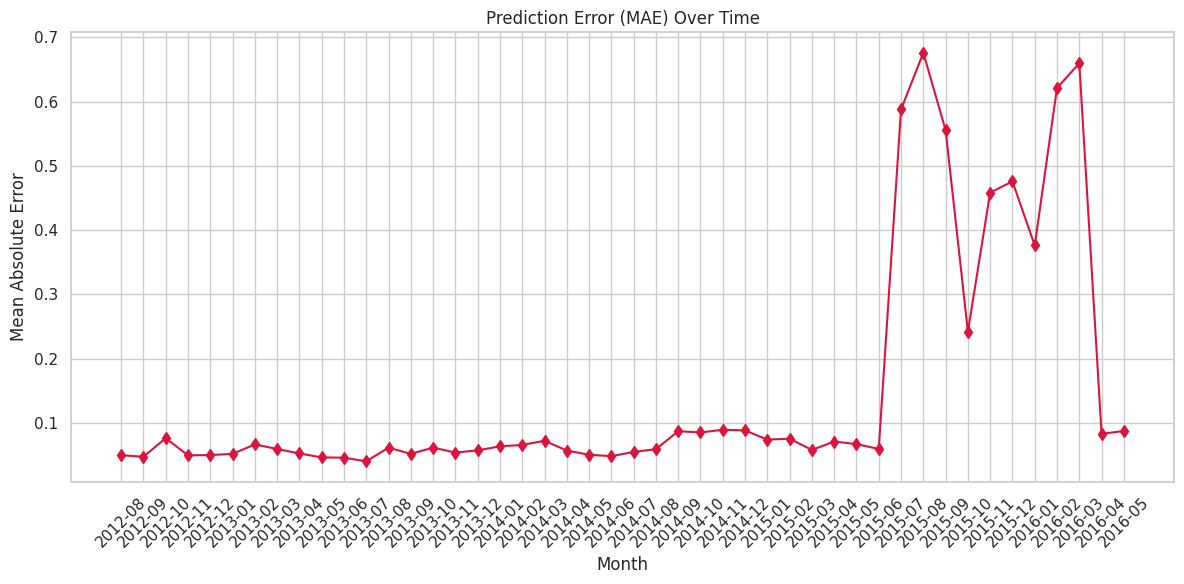

In [98]:
monthly_errors = []

for snapshot, month in zip(test_snapshots, all_months[len(train_snapshots):]):
    actual = snapshot.y.numpy()
    pred = model(snapshot.x.unsqueeze(0).to(device), snapshot.edge_index.to(device)).squeeze(0).cpu().detach().numpy()

    mae = np.mean(np.abs(pred - actual))
    monthly_errors.append({'month': month, 'mae': mae})

df_mae = pd.DataFrame(monthly_errors)

plt.figure(figsize=(12, 6))
plt.plot(df_mae['month'], df_mae['mae'], color='crimson', marker='d')
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Mean Absolute Error')
plt.title('Prediction Error (MAE) Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()
